In [227]:
% matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
import os
from scipy.sparse import coo_matrix

In [228]:
# Calculate RMSE for ratings prediction
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [229]:
# load in dataset
import mysql.connector
import yaml

cfg = yaml.safe_load(open('_inc.yaml'))
cnx = mysql.connector.connect(user=cfg['mysql']['user'], password=cfg['mysql']['pwd'],
                            host=cfg['mysql']['server'], database=cfg['mysql']['db'])

# load games dataset
games = pd.read_sql_query("select * from tblGame;", cnx)
# load tv shows dataset
tv = pd.read_sql_query("select * from tblTVShow;", cnx)
# load movies dataset
movies = pd.read_sql_query("select * from tblMovie;", cnx) 
# load Reviews
reviews = pd.read_sql_query("select * from tblReview;", cnx)

In [230]:
# products_dataset
products_dataset = games[['uniqueID', 'name']].append(movies[['uniqueID', 'name']]).append(tv[['uniqueID', 'name']])

In [241]:
# Restricting to user_reviews for 
users = reviews[reviews['reviewType']=='u']
users = users[['uniqueID','author', 'score']]
users.head(5)

,uniqueID,author,score
514304,20417,swing,3
514305,20417,cwongx,10
514306,20417,jmmarch,3
514307,20417,RatedRex,8
514308,20417,Morphine_OD,0


In [242]:
users = users[users.author!=""]
# filter with authors >1
authors = users.groupby(['author']).agg('count')
author_gtone = authors[authors['score'] > 20].index
# take only those authors
users = users[users['author'].isin(author_gtone)]

In [244]:
user_item_matrix = pd.pivot_table(users, values = 'score', index = ['author'], columns = ['uniqueID'], aggfunc=np.max)

# take off anonymous reviews
user_item_matrix = user_item_matrix.iloc[1:,]

# delete any games that only had anonymous reviews
user_item_matrix  = user_item_matrix.dropna(axis = 1, how = 'all')
# fill na to zero
data = user_item_matrix.fillna(0)

In [245]:
# normalize item_user_matrix by each user's mean
R = data.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [246]:
#################### BASELINE RMSE FOR COMPARISON TO SVD MODEL 

In [247]:
# baseline 
R_demeaned_mean = np.mean(R_demeaned)
baseline_average_prediction = np.ones([R.shape[0], R.shape[1]])*R_demeaned_mean 
baseline_rmse = rmse(baseline_average_prediction, R)

In [248]:
baseline_rmse

7.496572563457326

In [249]:
#################### SVD Implementation

In [250]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)
sigma = np.diag(sigma)

In [251]:
# Making a prediction from decomposed matrix
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [252]:
model_rmse = rmse(all_user_predicted_ratings, R)

In [260]:
print "Baseline RMSE: %.2f" %baseline_rmse
print "Model rmse: %.2f" %model_rmse
print "Improvement from baseline model(in percentage): %.2f" %((baseline_rmse-model_rmse)/baseline_rmse*100)

Baseline RMSE: 7.50
Model rmse: 6.07
Improvement from baseline model(in percentage): 19.07


In [254]:
################## Recommendation

In [261]:
# Making product recommendation
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = data.columns)
preds_df.head()

uniqueID,1,3,4,5,6,11,13,14,15,16,...,27849,27850,27851,27853,27855,27857,27858,27860,27862,27864
0,0.000257,0.216988,0.023564,-0.000069,0.016538,-0.108562,-0.082281,0.000096,0.014074,-0.047849,...,-0.039618,-0.002232,0.004483,-0.191171,-0.028063,-0.123313,0.004078,-0.018301,-0.016706,-0.085380
1,-0.012939,-0.003202,-0.023965,-0.013502,-0.023269,0.028193,0.018078,0.009370,-0.014735,-0.011735,...,0.011269,-0.001872,0.004668,0.124536,-0.045588,0.002927,-0.002293,0.023884,-0.052057,0.018577
2,0.014395,0.035838,0.012538,0.014338,0.035406,-0.000533,-0.003850,0.014538,0.014073,0.020838,...,0.020129,0.016939,0.013256,0.162350,0.080395,0.036768,0.017444,0.028209,0.007083,0.057905
3,-0.001484,0.060357,0.010389,-0.001514,-0.031809,0.105464,0.110920,-0.004813,-0.007330,0.073388,...,0.053736,-0.002449,0.004490,0.442672,0.335339,0.125881,0.000165,0.025330,0.078264,-0.006648
4,0.005022,-0.045479,0.005971,0.005144,0.030125,-0.002473,-0.004256,0.006161,0.013078,0.026315,...,-0.030636,-0.001537,-0.000942,-0.047013,0.123860,0.040400,0.035940,0.005045,-0.113621,0.181534


In [262]:
user_row_number = 4
sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False)

In [263]:
"""
reccommend returns even items that a user has recommended highly
"""
def recommend(user_row_number, preds_df, info_df, user_item_df, top_n=5):
    # History
    user_history = user_item_df.iloc[[user_row_number,]]
    ids = user_history.columns[~((user_history==0).all())]
    # add in data frame infromation
    history = pd.merge(pd.DataFrame(ids),products_dataset[['uniqueID', 'name']],how="left", on ="uniqueID") 
    # add ratings information
    history = pd.merge(history, user_history.T.reset_index(), on= "uniqueID", how="left")
    
    
    # prediction
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False)
    recommendation = sorted_user_predictions.sort_values(ascending=False).iloc[:top_n]
    result = pd.merge(recommendation.reset_index()[['uniqueID']], info_df[['uniqueID', 'name']],how="left", on ="uniqueID")
    return result, history
    
suggestions, history = recommend(4, preds_df, products_dataset, data, 5)    

In [321]:
history.head(5)

,uniqueID,name,43in2014
0,20446,Kubo and the Two Strings,6.0
1,20468,Moana,10.0
2,20474,Your Name,10.0
3,20505,The Jungle Book,10.0
4,20875,Ida,6.0


In [265]:
suggestions

,uniqueID,name
0,20505,The Jungle Book
1,20421,La La Land
2,23833,The Nice Guys
3,24877,Doctor Strange
4,20789,Inside Out


In [266]:
"""
collaborative_recommend returns new items only
"""
def collaborative_recommend(user_row_number, preds_df, info_df, user_item_df, top_n=5):
    # History
    user_history = user_item_df.iloc[[user_row_number,]]
    ids = user_history.columns[~((user_history==0).all())]
    # add in data frame infromation
    history = pd.merge(pd.DataFrame(ids),products_dataset[['uniqueID', 'name']],how="left", on ="uniqueID") 
    # add ratings information
    history = pd.merge(history, user_history.T.reset_index(), on= "uniqueID", how="left")
    
    # prediction
    sorted_user_predictions = preds_df.loc[user_row_number,user_item_df.iloc[user_row_number,:]==0].sort_values(ascending=False)
    recommendation = sorted_user_predictions.sort_values(ascending=False).iloc[:top_n]
    result = pd.merge(recommendation.reset_index()[['uniqueID']], info_df[['uniqueID', 'name']],how="left", on ="uniqueID")
    return result, history
    
suggestions, history = collaborative_recommend(4, preds_df,games,data,10)    
suggestions

,uniqueID,name
0,20421,NaN
1,23833,NaN
2,20789,NaN
3,20503,NaN
4,21104,NaN
5,20955,NaN
6,21017,NaN
7,21062,NaN
8,23878,NaN
9,24715,NaN


In [269]:
#save pickle file
import pickle
with open('user_item_matrix_smaller.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [149]:
############ Functions for Flask App 

In [196]:
# load pickle file of preloaded pivot table
from scipy.sparse.linalg import svds
import pickle

#to load a pickle file
with open('user_item_matrix.pickle', 'rb') as f:
    user_item_matrix = pickle.load(f)


In [197]:
d ={1:10, 2:10}
last = user_item_matrix.shape[0]
user_item_matrix = add_score(d, user_item_matrix)
preds_df = predict_svd(user_item_matrix)
collaborative_recommend(last-1, preds_df, user_item_matrix,5) 

Int64Index([6320, 6393, 6162, 6058, 10810], dtype='int64', name=u'uniqueID')

In [151]:
# function takes in input from users and adds it to user_item matrix
"""
add_score: adds a dictionary of values rated obtained from user to the user_matrix
d should be formated as: type: dictionary, format: {'uniqueID': 'score'}
"""
def add_score(d, user_matrix):
    last = len(user_matrix)
    user_matrix.loc[len(user_matrix),d.keys()[0]] = d.values()[0]
    if len(d)>1:
        for i in range(1, len(d)):
            user_matrix.loc[last,d.keys()[i]] = d.values()[i]
    return user_matrix.fillna(0)

In [167]:
"""
predict_svd: takes a user_item_matrix and returns a matrix of same shape with all ratings predictions
"""

def predict_svd(user_item_matrix):
    # change type and normalize ratings for SVD
    R = user_item_matrix.as_matrix()
    user_ratings_mean = np.mean(R, axis = 1)
    R_demeaned = R - user_ratings_mean.reshape(-1, 1)
    
    # svd
    U, sigma, Vt = svds(R_demeaned, k = 50)
    sigma = np.diag(sigma)
    
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = user_item_matrix.columns)
    
    return preds_df

In [170]:
"""
collaborative_recommend returns a list with of uniqueIDs of recommended items
"""
def collaborative_recommend(user_row_number, preds_df, user_item_df, top_n=5):
    sorted_user_predictions = preds_df.loc[user_row_number,user_item_df.iloc[user_row_number,:]==0].sort_values(ascending=False)
    recommendation = sorted_user_predictions.sort_values(ascending=False).iloc[:top_n]
    return recommendation.index
    
suggestions = collaborative_recommend(4, preds_df, user_item_matrix,5)    


In [198]:
# Train/test split to check which value of K to use in the SVD model

In [270]:
# split train and test dataset

# Define a function for splitting train/test data.
def split_train_test(data, percent_test=10):
    """Split the data(user to item matrix) into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10.
    """
    n, m = data.shape             # # users, # games
    N = n * m                     # # cells in matrix

    # Prepare train/test ndarrays.
    train = data.copy().values
    test = np.ones(data.shape) * np.nan

    # Draw random sample of training data to use for testing.
    tosample = np.where(~np.isnan(train))       # ignore nan values in data
    idx_pairs = zip(tosample[0], tosample[1])   # tuples of row/col index pairs
    indices = np.arange(len(idx_pairs))         # indices of index pairs
    
    test_size = len(indices) / percent_test  # use 10% of data as test set
    train_size = len(indices) - test_size    # and remainder for training
    
    sample = np.random.choice(indices, replace=False, size=test_size)

    # Transfer random sample from train set to test set.
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]  # transfer to test set
        train[idx_pair] = np.nan          # remove from train set

    # Return train set, test set
    return train, test

train, test = split_train_test(user_item_matrix)
# Training dataset
R_train = np.nan_to_num(train)
train_user_ratings_mean = np.mean(R_train, axis = 1)
R_train_demeaned = R_train - train_user_ratings_mean.reshape(-1, 1)
# Test dataset
R_test = np.nan_to_num(test)

In [298]:
# Cross-validation  function
def svd_cv(train,test, k_list):
    train_rmse_list = []
    test_rmse_list = []
    
    # Training dataset
    R_train = np.nan_to_num(train)
    train_user_ratings_mean = np.mean(R_train, axis = 1)
    R_train_demeaned = R_train - train_user_ratings_mean.reshape(-1, 1)
    
    # Test dataset
    R_test = np.nan_to_num(test)
    
    for i in k_list:
        # SVD on training set
        U, sigma, Vt = svds(R_train_demeaned, k = i)
        sigma = np.diag(sigma)
    
        # Making a prediction from decomposed train matrix
        all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + train_user_ratings_mean.reshape(-1, 1)
    
        # train error
        train_rmse = rmse(all_user_predicted_ratings, R_train)
        train_rmse_list  = train_rmse_list + [train_rmse]
    
        # test error
        test_rmse = rmse(all_user_predicted_ratings, R_test)
        test_rmse_list  = test_rmse_list + [test_rmse]
        
        print "(k=%i)Training error: %.2f, Test error: %.2f" %(i,train_rmse,test_rmse)
    
    
    return train_rmse_list, test_rmse_list
    

In [301]:
k_list = range(1,100)
train_rmse_list, test_rmse_list = svd_cv(train,test,k_list)

(k=1)Training error: 7.31, Test error: 7.35
(k=2)Training error: 7.17, Test error: 7.24
(k=3)Training error: 7.09, Test error: 7.17
(k=4)Training error: 7.03, Test error: 7.13
(k=5)Training error: 6.97, Test error: 7.10
(k=6)Training error: 6.92, Test error: 7.07
(k=7)Training error: 6.88, Test error: 7.04
(k=8)Training error: 6.84, Test error: 7.01
(k=9)Training error: 6.81, Test error: 7.00
(k=10)Training error: 6.78, Test error: 6.99
(k=11)Training error: 6.75, Test error: 6.98
(k=12)Training error: 6.72, Test error: 6.97
(k=13)Training error: 6.70, Test error: 6.96
(k=14)Training error: 6.68, Test error: 6.95
(k=15)Training error: 6.66, Test error: 6.95
(k=16)Training error: 6.64, Test error: 6.95
(k=17)Training error: 6.62, Test error: 6.94
(k=18)Training error: 6.60, Test error: 6.94
(k=19)Training error: 6.58, Test error: 6.94
(k=20)Training error: 6.56, Test error: 6.93
(k=21)Training error: 6.54, Test error: 6.93
(k=22)Training error: 6.52, Test error: 6.92
(k=23)Training erro

In [ ]:
# plot train and test error

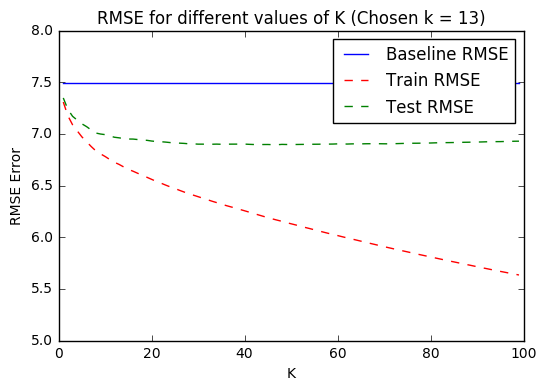

In [319]:
import matplotlib.pyplot as plt
k_list = range(1,100)
baseline_error = np.repeat(baseline_rmse,99)
training_error = train_rmse_list
test_error = test_rmse_list
plt.plot(k_list, baseline_error, label='Baseline RMSE')
plt.plot(k_list, training_error, linestyle='--', color='r', label='Train RMSE')
plt.plot(k_list, test_error, linestyle='--', color='g', label='Test RMSE')
plt.xlabel('K')
plt.ylabel('RMSE Error')
plt.title('RMSE for different values of K (Chosen k = 13)')
plt.legend()
plt.axis((0,100,5,8))
plt.show()